### MSc Data Analytics

#### CA2 - Integrated Assignment sem2

#### 2020274 - Clarissa Cardoso

##### Github repository: https://github.com/clarissa2020274/2020274_CA2_sem2.git


### Time series Forecasting using new notebook within venv.

This is the second notebook that was created to use all the packages that were needed to instal via virtual environment to perfom the Timeseries analysis for the CA2 of Msc DA.

It contains the last two sections for experimentation of timeseries forecasting models
> Sections 4 and 5 will be deployed on a separate Jupyter Notebook because of compuational issues within Ubuntu Os.
 When attempting to clear space in local disk, a few libraries inicially used for the project were not able to be updated when the system kept freezing for lack of space. The solution found was to reinstall all necessary packages through a virtual enviroment where the new Notebook (2020274_MScDA_CA2_Clarissa_SecondNotebook.ipynb) will be used for experimentation of timeseries contruction. Once the data prepocessing and cleaning was complete, a new file was stored in HDFS and local drive to enable access from multiple sources.

- Section four centers on creating the time-series model and selection of apropriate parametrers and hyperparameters to run it.

- Fifth section relies on training the model and validating/reacessing features that can be modified for better performance and compare model's results.



In [1]:

# importing necessary libraries to deploy pyspark functions

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import max as max_


from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from bs4 import BeautifulSoup  # For HTML parsing
from pyspark.sql.functions import lower

import numpy as np # for numerical operations.
import pandas as pd

import matplotlib.pyplot as plt # visualization
%matplotlib inline 


import warnings # Ignore warnings.
warnings.filterwarnings("ignore")


from sklearn.preprocessing import RobustScaler, PowerTransformer # Importing scalling tools.
from statsmodels.tsa.seasonal import seasonal_decompose # Imports seasonal decompose for time-series analysis.
from statsmodels.tsa.stattools import adfuller # Statistical test for stationarity.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Auto-correlation plots for time-series analysis.
from statsmodels.tsa.ar_model import AutoReg # Imports Auto Regressive
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error # Imports metrics for evaluation.
from scipy import stats # Stats is for Shapiro test (normality).
from statsmodels.tsa.arima.model import ARIMA # ARIMA time series model.
from statsmodels.tsa.statespace.sarimax import SARIMAX# Imports SARIMA
import itertools # For hyper-parameter tunning.
import pmdarima as pm # Imports pmdarima to find optimal order values.
from pmdarima import auto_arima # Imports auto_arima for optimal parameters.


In [2]:
#import subprocess
#
# Saving the original file of sentiments extracted to local file path
#local_file_path = "/home/hduser/Downloads/SentimentData.csv"
# Assuming the HDFS directory
#hdfs_directory = "hdfs:///user/hduser/CA2"

# Use subprocess to run the hdfs dfs -copyFromLocal command
#subprocess.run(["hdfs", "dfs", "-copyFromLocal", local_file_path, hdfs_directory])

## code is purposly left with comments to avoid duplicating the files in local system and hdfs.





### Importing file with complete date range and imputations of mean values 


In [3]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("TimeSeries").getOrCreate()

# Specify the HDFS path to your CSV file
hdfs_path = "hdfs:///user/hduser/CA2/ImputData.csv"

# Read the CSV file into a PySpark DataFrame
pyspark_df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Show the first few rows of the PySpark DataFrame
pyspark_df.show()

# Convert PySpark DataFrame to Pandas DataFrame to apply statsmodels features
pandas_df = pyspark_df.toPandas()


+----------+---------+---------------+
| date_only|sentiment|sentiment_score|
+----------+---------+---------------+
|2009-04-07|      0.0|        -0.3818|
|2009-04-07|      0.0|        -0.7269|
|2009-04-07|      1.0|         0.4939|
|2009-04-07|      1.0|          -0.25|
|2009-04-07|      0.0|        -0.4939|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.4767|
|2009-04-07|      1.0|         0.8481|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|        -0.5994|
|2009-04-07|      0.0|        -0.1027|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.2732|
|2009-04-07|      0.0|        -0.9081|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.6369|
|2009-04-07|      1.0|         0.1779|
+----------+---------+---------------+
only showing top 20 rows



In [4]:
pandas_df.head()

,date_only,sentiment,sentiment_score
0,2009-04-07,0.0,-0.3818
1,2009-04-07,0.0,-0.7269
2,2009-04-07,1.0,0.4939
3,2009-04-07,1.0,-0.2500
4,2009-04-07,0.0,-0.4939


In [5]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date_only        1600039 non-null  object 
 1   sentiment        1600000 non-null  float64
 2   sentiment_score  1600039 non-null  float64
dtypes: float64(2), object(1)
memory usage: 36.6+ MB


### Data Preparation for Time Series Forecasting

To prepare the data for applying the models required for forecasting, its important to extract only the necessary features. In this case, date_only and sentiment_score will be used fro modeling. But first the date need to be reset as the index with the correct dtype.



In [6]:
# set date as datetime
pandas_df['date_only'] = pd.to_datetime(pandas_df['date_only'])
pandas_df.set_index('date_only', inplace=True)

# Create a new DataFrame with only 'sentiment_score'
new_df = pandas_df[['sentiment_score']].copy()
new_df.head()

,sentiment_score
date_only,
2009-04-07,-0.3818
2009-04-07,-0.7269
2009-04-07,0.4939
2009-04-07,-0.2500
2009-04-07,-0.4939


## Visualise the time series 


The simplistic plot below of the raw  dataset does not give many insights, even with applying the seasonal decomposition, all the components needed to unsertand the data's patterns are 'messy' and difficult to measure.

That happens because there are several observations for the same dates in the dataset imported, considering also the data constais the imputations added on the first notebook used in the project. 

The next attempt of plotting the line correctly, as well as perfoming decomposition, will be done only after obtaining the daily average sentiment score. In this way, creating a new dataframe containing only one observation per day, which is the mean score of the days added together. 

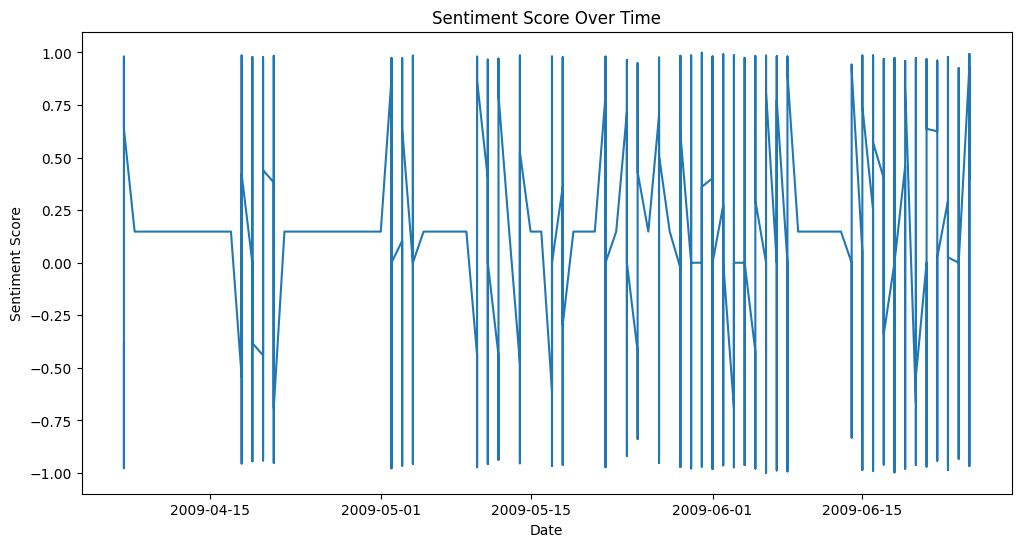

In [7]:
# create figure to see how the values change over time
plt.figure(figsize=(12, 6))
plt.plot(new_df['sentiment_score'])
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

## Seasonal decompose using additive model 

This is just an example to see if the libraries are working well. Also, there is not much information that can be extracted from the decomposition of the entire dataset, as mentioned before, this feature will display the actual trend and seasonality oscilation once we get the average values per day. 

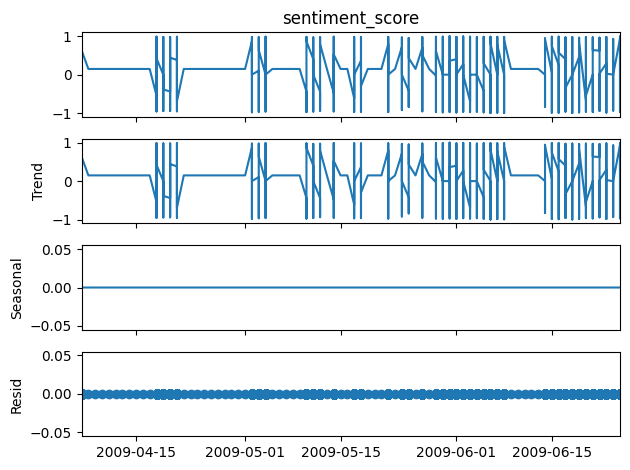

In [8]:
result = seasonal_decompose(new_df['sentiment_score'], 
                            model='additive', 
                            period=1)  # need to adjust the period, to weekly or maybe even montly
result.plot()
plt.show()

## Calculate the average sentiment score per day 

This will make sure the is only one observation of score per day. There are more complete ways of perfoming this, like calulating the weighted average, considering the weight of each score observed which could provide a more detailed analysis, but since there were too many errors with the ubuntu disk space, I will only use the overall average to perform a more simple modelling only for experimentation purposes. 


In [9]:
# Setting date_only as the index
# And calculate the daily average to obtain a more robust data
average_sentiment_per_day = new_df.groupby('date_only')['sentiment_score'].mean()

# Convert the result to a DataFrame
daily_average_df = average_sentiment_per_day.reset_index()

# Set 'date_only' as the index
daily_average_df.set_index('date_only', inplace=True)



<b>Before compiling the new dataframe for seasonal decompose, check the descriptive statistics and  visualise the distribution of datapoints over time

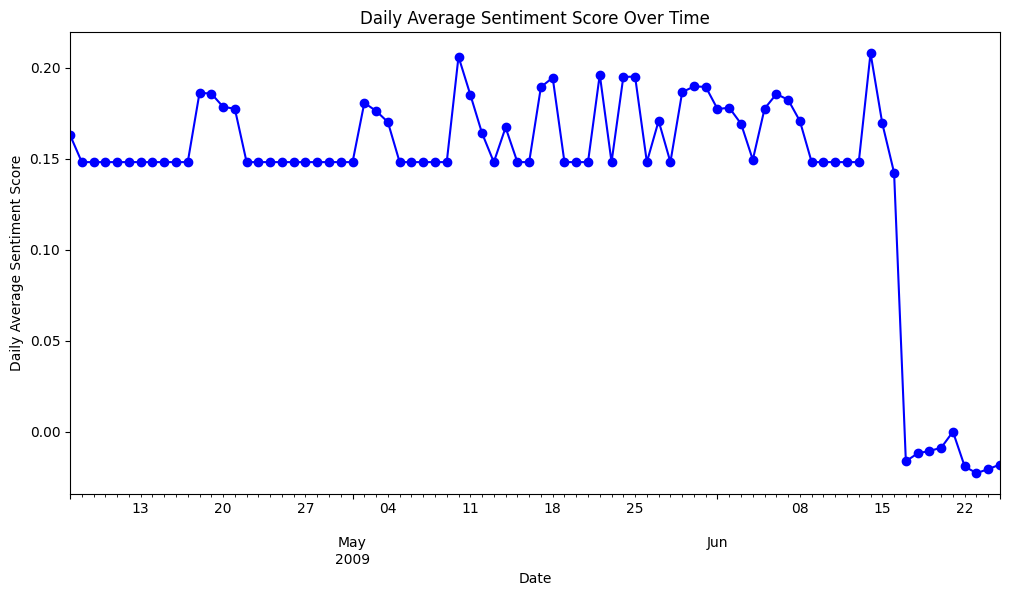

In [10]:
# Assuming 'daily_average_df' is your DataFrame with 'date_only' as the index and 'sentiment_score' column
plt.figure(figsize=(12, 6))
daily_average_df['sentiment_score'].plot(marker='o', linestyle='-', color='b')

# Adding labels and title
plt.title('Daily Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Average Sentiment Score')

# Display the plot
plt.show()

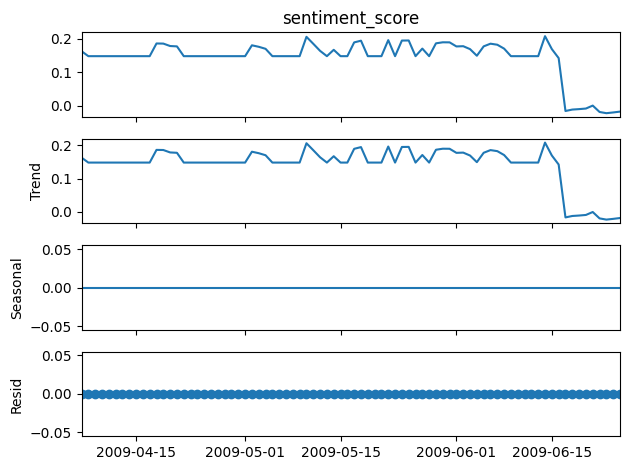

In [11]:
# Perform seasonal decomposition
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=1) #daily logs

# Plot the results
result.plot()
plt.show()

In this plot is possible to see a simplistic version of the overall positive trend of the sentiment scores, with a sharp drop towards the end. This suggests a unusual and non constant  pattern in the data, however, with the period set to daily logs(period=1), both the seasonal component and residuals look flat, but when the decomposition is applied to the average scores and considering the weekly period (=7), the pattern also changes quite significantly. 



In [12]:
display(daily_average_df.head())
print(daily_average_df.info())
display(daily_average_df.describe())

,sentiment_score
date_only,
2009-04-07,0.163041
2009-04-08,0.148130
2009-04-09,0.148130
2009-04-10,0.148130
2009-04-11,0.148130


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2009-04-07 to 2009-06-25
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  80 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB
None


,sentiment_score
count,80.000000
mean,0.142572
std,0.058925
min,-0.022878
25%,0.148130
50%,0.148130
75%,0.177358
max,0.208055


## Changing period of decomposition to identify any other related seasonality by week, bi-weekly and monthly


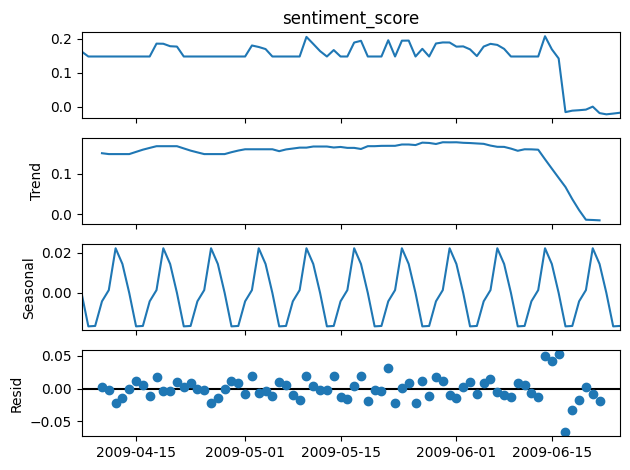

In [13]:
# Perform seasonal decomposition weekly
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=7) # starting to observe a pattern 

# Plot the results
result.plot()
plt.show()

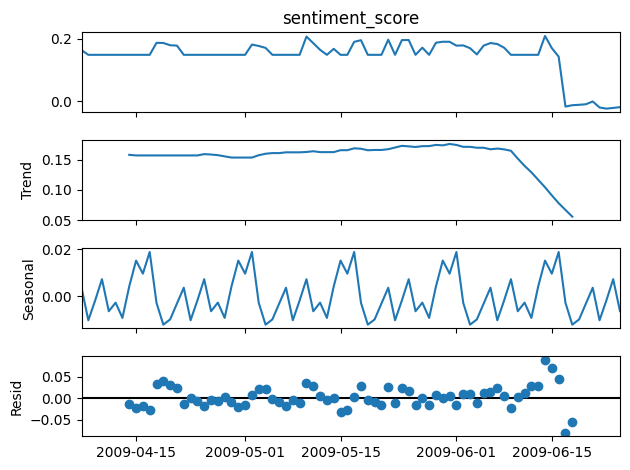

In [14]:
# Perform seasonal decomposition bi-weekly?
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=15) #testing the different possibilities

# Plot the results
result.plot()
plt.show()

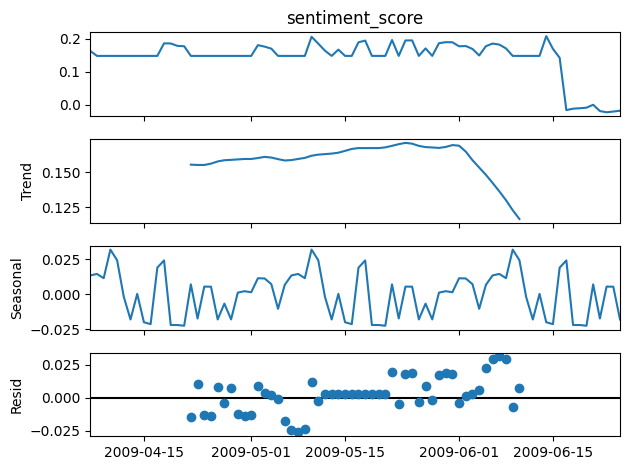

In [15]:
# Perform seasonal decomposition monthly?
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=30)

# Plot the results
result.plot()
plt.show()

#### A few insights from the decomposition: 
The seasonal plot shows some patterns repeating every 15 data points (bi-weekly), it suggests that there is a certain bi-weekly seasonality in the sentiment scores. In the same time,  the residuals are mostly random and don't show any discernible patterns, suggesting the decomposition has captured the underlying structure in the data. Usually, literature says that residual component epresents the random fluctuations or noise in the data that cannot be explained by the trend and seasonal components. It is essentially what remains after removing the trend and seasonality (Paudyal, 2020). 
But since the range of dates is not adjustable to b--weekly, the chosen period for the analysis of decmoposition and differenciation will be 7(week by week) 


 In this case, by selecting the parameter 'extrapolate_trned': trend will be extrapolated to the frequency of the time series and the decomposition components can be better visualised by plotting them individually using subplots.

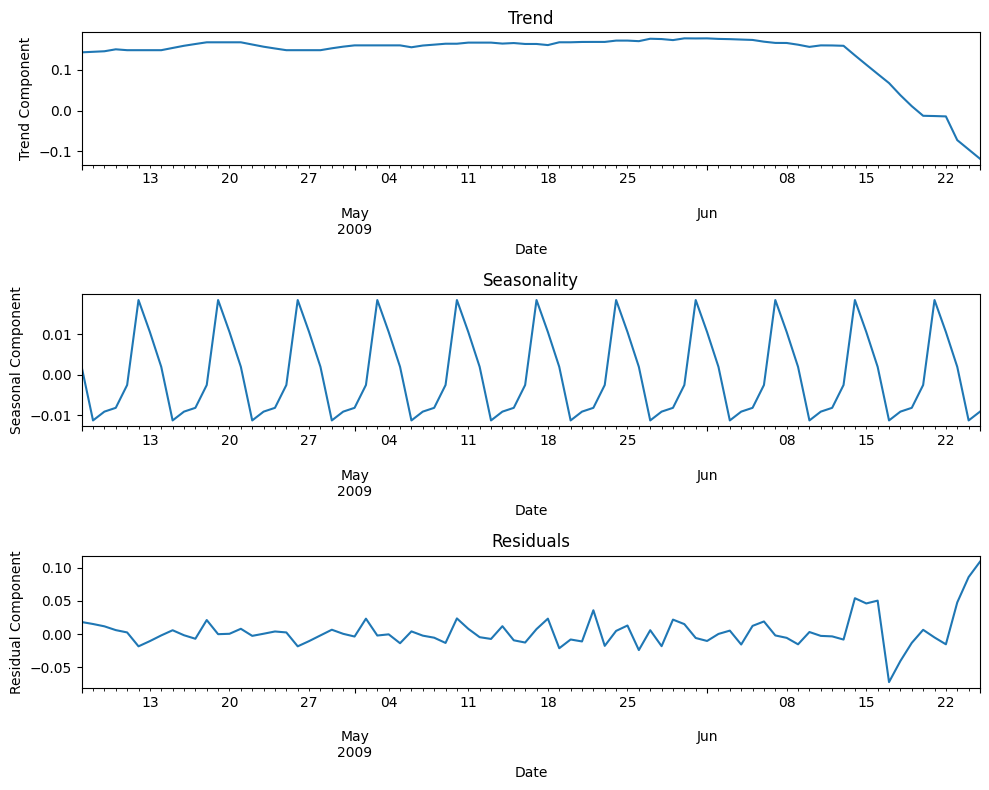

In [16]:
# Decomposing the time series.
decomposition = seasonal_decompose(daily_average_df['sentiment_score'], 
                                   model='additive', 
                                   period=7,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

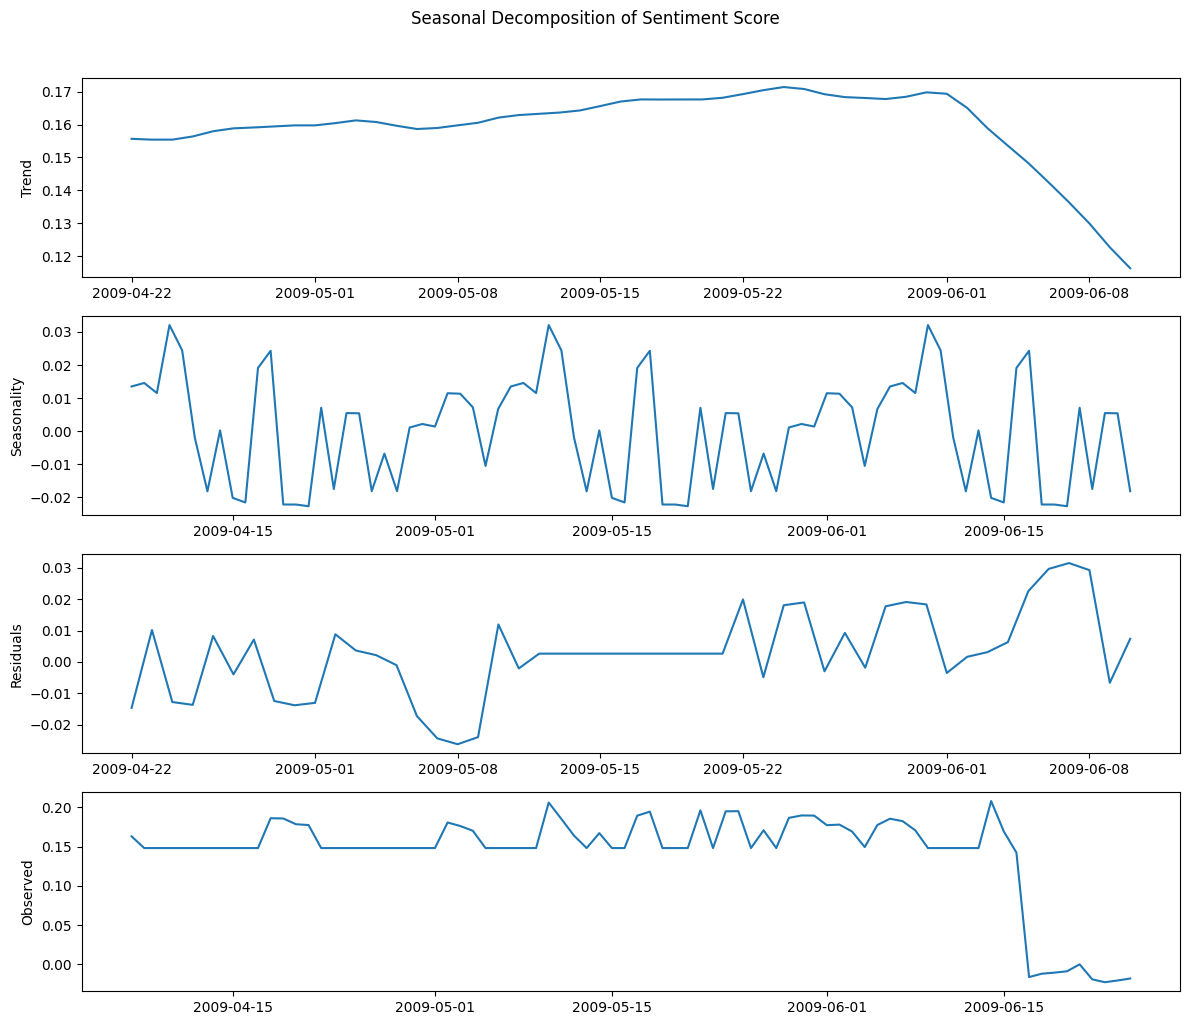

In [17]:
#comparing the decomposed components with the original data 


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

ax1.set_ylabel('Trend') # estimated trend componenent
ax2.set_ylabel('Seasonality') # seasonal component with weekly pattern
ax3.set_ylabel('Residuals') # whats left after removing the first 2 components
ax4.set_ylabel('Observed') # original sentiment over time

#plot components individually
ax1.plot(result.trend)
ax2.plot(result.seasonal)
ax3.plot(result.resid)
ax4.plot(result.observed)

plt.suptitle('Seasonal Decomposition of Sentiment Score', y=1.02)
plt.tight_layout()
plt.show()

### Autocorrelation (ACF) and Partial Correlation  (PACF)

<Figure size 1400x700 with 0 Axes>

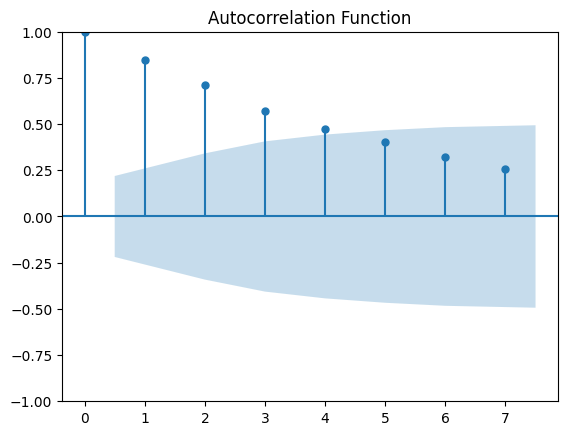

<Figure size 1400x700 with 0 Axes>

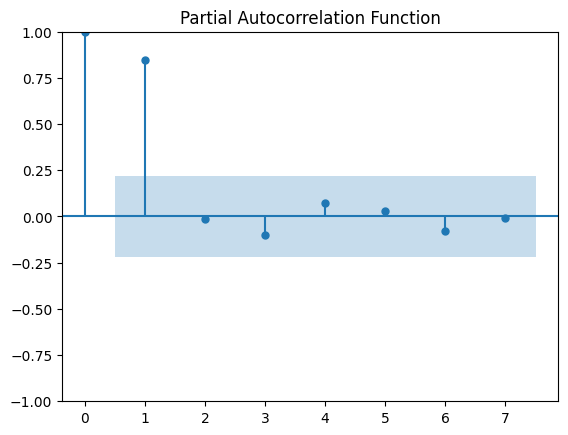

In [18]:
# Since the frequency used in decomp. is in days, the lags used for the plots is 7 also.
n_lags = 7

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(daily_average_df['sentiment_score'], lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(daily_average_df['sentiment_score'], lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()

## Checking for stationarity of the data



    A simple definition for stationaey or non-stationary data from Paudyal (2020) is that the "*stationarity of data depends on the constant behaviour of mean, variance over time, and co-variance. A flat looking trend means there i no significant variation in the statistical properties of the data. In non-stationary, mean, variance and co-variance increases with time Most of the raw data collected will be non-stationary data. A non- stationary time series will affect the forecasting of time series. Therefore, data needs to be changed to stationary before analysis."*


References: 

-Times Series in Python, Pragya Paudyal (2020) Available at: https://medium.com/@pragya_paudyal/time-series-in-python-2b786a904951#:~:text=You%20can%20make%20a%20non,diff()%20method

-An Introduction To Non Stationary Time Series In Python, Aishwarya Singh (2020) Available at:  https://analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

-How to Check if Time Series Data is Stationary with Python, Jason Brownlee (2020) https://machinelearningmastery.com/time-series-data-stationary-python/

### Augmented Dickey-Fuller test

The first test applied is the adf, one of the most popular statistical tests available to check the stationarity of a timeseries.

Based on the high p-value (0.96) from the results, it indicates that we fail to reject the null hypothesis. 
Meaning that the time series has a unit root and is non-stationary data. 


The secons is the 
https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html



In [19]:
# Augmented Dickey-Fuller test
adf_test = adfuller(daily_average_df['sentiment_score'],  maxlag=7, autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': 0.09390855995835587,
 'p-value': 0.9656427339573328,
 'Lags Used': 7,
 'Number of Observations Used': 72,
 'Critical Values': {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677}}

### KPSS test 
Also checks the stationarity of a time series. According to statsmodels documentation: "the null and alternate hypothesis for the KPSS test are opposite that of the ADF test", so the p-value < 0.05 in this case (0.048) also corroborates the non-statioanary hypotesis. 

In [20]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
#apply the test

kpss_test(daily_average_df['sentiment_score'])

Results of KPSS Test:
Test Statistic           0.470223
p-value                  0.048373
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


As the adf test indicates the data is highly non-stationary, there are a few paths to persue. 

A differenciating technique can be applied in order to try transforming the sentiment scores to a stationary behaviour before applying forecasting models. Another option is to perfom specific models that can be used for this kind of inputs. Paudyal (2020) also mentions there are other techniques to use to make the data stationary, including creating several df.diff() funtions over the previous results until achieve the most optimal result. 

The logarithmic transformation for example, will take the log values of the original data, however, since the sentiment_score varies between positive and negative values, even though they are very close to 0, this method would not be recommended for this specific data, since it can add biased values to the timeseries.


https://medium.com/@pragya_paudyal/time-series-in-python-2b786a904951#:~:text=You%20can%20make%20a%20non,diff()%20method.

## Using df.diff() to make the data stationary

this function uses the previous row values to calculate the first discrete difference of elements in the same column.  The first element in the result is NaN value because there's no previous value for the first row to compare.

In [21]:
# Differencing the sentiment scores
df = daily_average_df['sentiment_score'].diff(1)  # Difference with 7 lags


# Remove Nan values from first rows.
df = df.dropna()

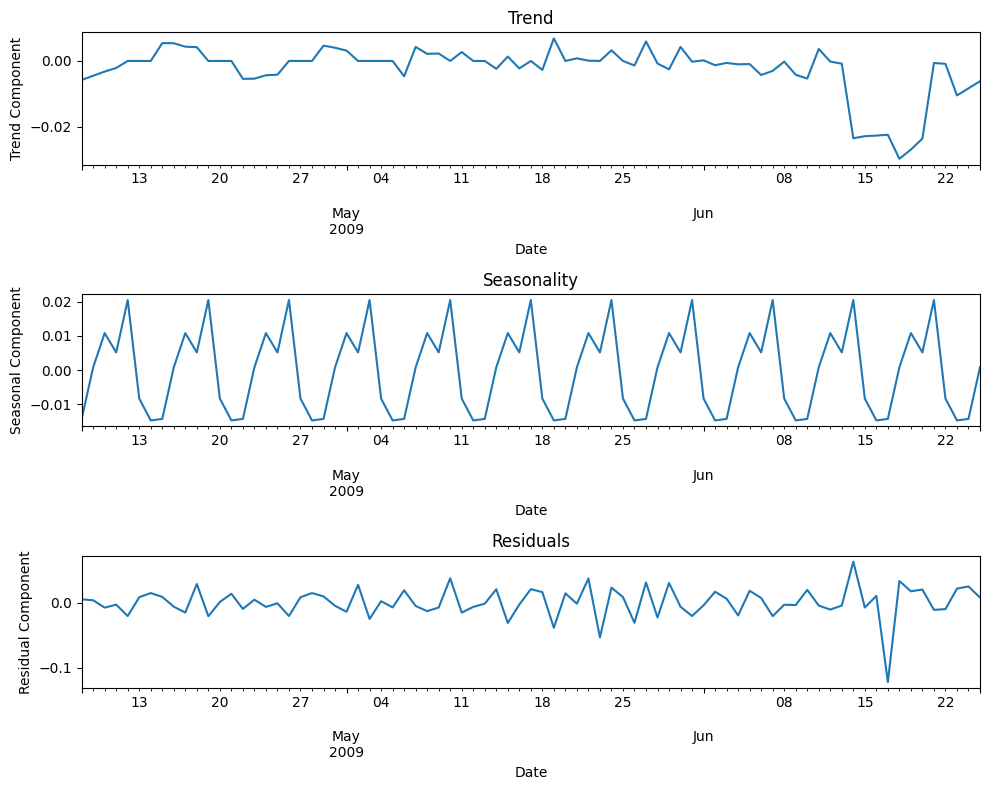

In [22]:
# Decomposing the time series.
decomposition = seasonal_decompose(df, 
                                   model='additive', 
                                   period=7, # by week
                                   extrapolate_trend='freq')

# Visualisation of decomposed components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() 

#display fig
plt.show()


In [23]:
# Augmented Dickey-Fuller test for diff data
adf_test = adfuller(df,  
                    maxlag=7, #keep the same period for maxlag
                    autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': -2.5852854474000395,
 'p-value': 0.09607676230384798,
 'Lags Used': 7,
 'Number of Observations Used': 71,
 'Critical Values': {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957}}

For the adf test on differenciated data, based on the p-value being greater than 0.05, there is not enough evidence to reject the null hypothesis of non-stationarity. 

The time series may still exhibit non-stationary behavior. To achieve stationarity, an additional transformation through diff() will be attemted.


In [24]:
# Differencing the sentiment scores for the second time
diff_df = df.diff()  # Difference with 1 lag

# Remove Nan values from the resulting DataFrame
diff_df = df.dropna()

In [25]:
# Perform ADF test for second diff data 
adf_test = adfuller(diff_df,  
                    maxlag=7, #keep the same period for maxlag
                    autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result



{'Test Statistic': -2.5852854474000395,
 'p-value': 0.09607676230384798,
 'Lags Used': 7,
 'Number of Observations Used': 71,
 'Critical Values': {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957}}

Got the same results on both diffs, 

In [26]:
seasoanl_df = daily_average_df['sentiment_score'].diff(7)  # seasonal difference
seasoanl_df = df.dropna()

In [27]:
# Perform ADF test for third diff data 
adf_test = adfuller(seasoanl_df,  
                    maxlag=7, #keep the same period for maxlag
                    autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result



{'Test Statistic': -2.5852854474000395,
 'p-value': 0.09607676230384798,
 'Lags Used': 7,
 'Number of Observations Used': 71,
 'Critical Values': {'1%': -3.526004646825607,
  '5%': -2.9032002348069774,
  '10%': -2.5889948363419957}}

Even using the seasonal difference with 7 lags, the p-value for the adf test keeps getting bigger and bigger. 

According to Paudyal(2020), there is also the option to use the squared root to make the data stationary:


In [28]:
# Assuming df is your time series
df = daily_average_df['sentiment_score']

# Take the square root of the time series
df_sqrt = np.sqrt(df)

# Difference the square root-transformed series
df_diff_sqrt = df_sqrt.diff(1)  # You can adjust the lag parameter as needed

# Drop NaN values
df_diff_sqrt = df_diff_sqrt.dropna()

###  ADF test for df_diff_sqrt

In [29]:
# Perform ADF test for df_diff_sqrt
adf_test = adfuller(df_diff_sqrt,  
                    maxlag=7, #keep the same period for maxlag
                    autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result


{'Test Statistic': -3.63502257795558,
 'p-value': 0.005125709552569687,
 'Lags Used': 7,
 'Number of Observations Used': 62,
 'Critical Values': {'1%': -3.540522678829176,
  '5%': -2.9094272025108254,
  '10%': -2.5923136524453696}}

<Figure size 1400x700 with 0 Axes>

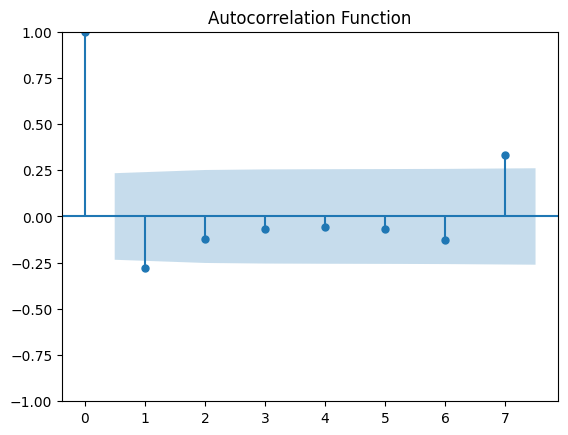

<Figure size 1400x700 with 0 Axes>

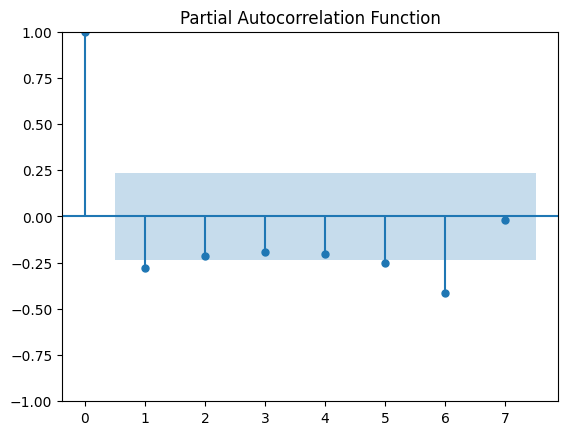

In [30]:
# Because the frequency is in days, the lags used for the plots is 7.
n_lags = 7

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(df_diff_sqrt, lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(df_diff_sqrt, lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()

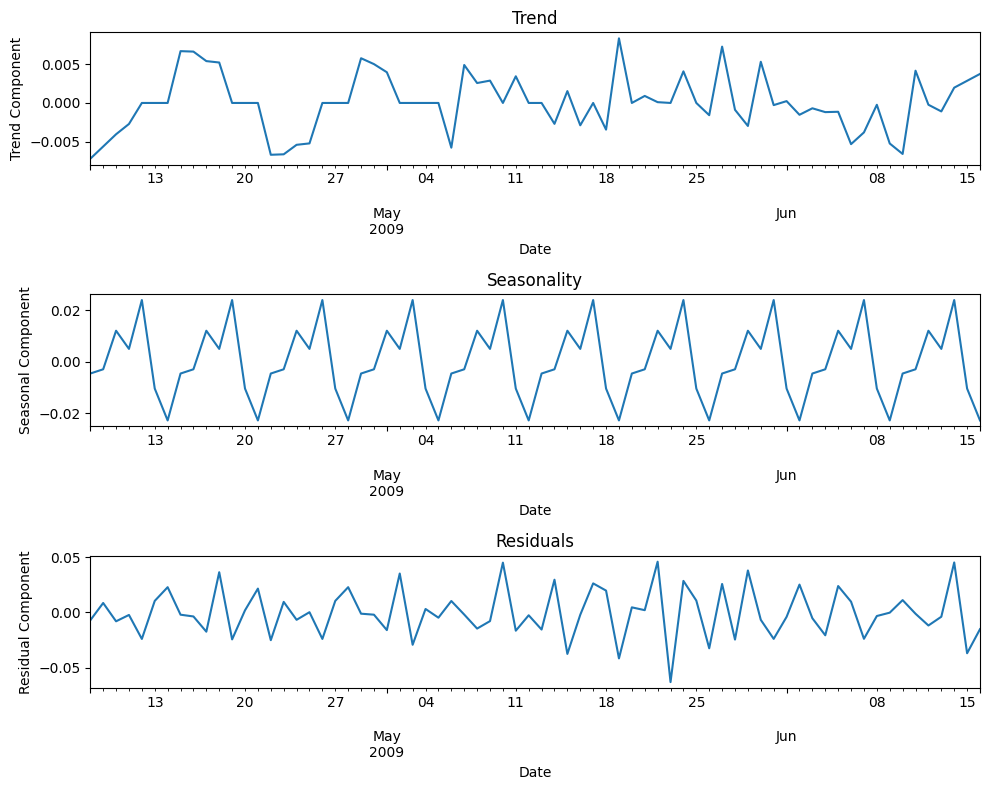

In [31]:
# Decomposing the time series.
decomposition = seasonal_decompose(df_diff_sqrt, 
                                   model='additive', 
                                   period=7,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

## Hyperparameter Tuning 

Grid search is simple but may be computationally expensive, while optimization libraries like Optuna and Ray Tune offer more sophisticated methods for finding optimal hyperparameters. Optuna is a hyperparameter optimization framework that supports optimization of any machine learning model. It is flexible and easy to use. https://optuna.org/#installation


In [32]:
import optuna
from statsmodels.tsa.arima.model import ARIMA

In [33]:
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

In [34]:
df_diff_sqrt.head()

date_only
2009-04-08   -0.018907
2009-04-09    0.000000
2009-04-10    0.000000
2009-04-11    0.000000
2009-04-12    0.000000
Name: sentiment_score, dtype: float64

In [35]:
df_diff_sqrt.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 70 entries, 2009-04-08 to 2009-06-16
Series name: sentiment_score
Non-Null Count  Dtype  
--------------  -----  
70 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


## Split into train and test data

For the initial splitting, it was used 80% of the dates for train and 20% for test. however, when considering the diferenciated data has droped a few observations from the original data, it might be more prudent, or rather safe to select a smaller sample for testing like a 90 to 10 ratio, since the squared values have a total of 70 non-null obseervations. 

In [36]:

from sklearn.model_selection import TimeSeriesSplit

# using 'df_diff_sqrt' as differenced and square root transformed time series
train_size = int(len(df_diff_sqrt) * 0.9)  # Adjust the split ratio as needed
train_data, test_data = df_diff_sqrt[:train_size], df_diff_sqrt[train_size:]


In [37]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Define the range of values for p and q
p_values = range(0, 10)  # Adjust the range based on your data and assumptions
q_values = range(0, 10)  # Adjust the range based on your data and assumptions

# Create combinations of p and q values
pq_combinations = list(itertools.product(p_values, [1], q_values))

# Initialize lists to store AIC values and orders
aic_values = []
orders = []

# Grid search through combinations
for order in pq_combinations:
    try:
        model = sm.tsa.ARIMA(df_diff_sqrt, order=order)
        results = model.fit()
        aic = results.aic
        aic_values.append(aic)
        orders.append(order)
    except:
        continue

# Find the indices of the top 3 AIC values
top3_indices = sorted(range(len(aic_values)), key=lambda k: aic_values[k])[:3]

# Display the top 3 best parameters
print("Top 3 Best Parameters:")
for i in top3_indices:
    print(f"AIC: {aic_values[i]}, Order: {orders[i]}")

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so in

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so in

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

Top 3 Best Parameters:
AIC: -320.5860010560161, Order: (7, 1, 5)
AIC: -319.95500718925626, Order: (6, 1, 9)
AIC: -319.4239307217006, Order: (7, 1, 7)


/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Autoregressive Integrated Moving Average (ARIMA)

### Using the best parameters order to model ARIMA


Top 3 Best Parameters:
- AIC: -320.5860010560161, Order: (7, 1, 5)
- AIC: -319.95500718925626, Order: (6, 1, 9)
- AIC: -319.4239307217006, Order: (7, 1, 7)


df_diff_sqrt
### ARIMA with best AIC parameters (7, 0, 5)

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE): 0.0010144893789806961
Root Mean Squared Error (RMSE): 0.03185104988820143
Mean Absolute Error (MAE): 0.02324053449593162
R-squared (R²): 0.13734226314098863
Mean Absolute Percentage Error (MAPE): 2792126894931222.00%
                               SARIMAX Results                                
Dep. Variable:        sentiment_score   No. Observations:                   63
Model:                 ARIMA(7, 0, 5)   Log Likelihood                 164.072
Date:                Wed, 22 Nov 2023   AIC                           -300.144
Time:                        14:17:38   BIC                           -270.140
Sample:                    04-08-2009   HQIC                          -288.343
                         - 06-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


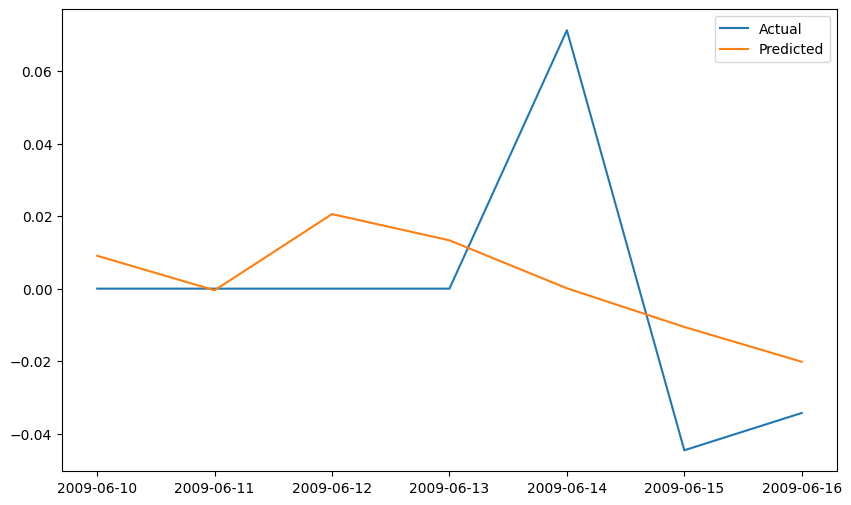

In [38]:

# Assuming 'train_data' and 'test_data' are your training and testing sets
model = sm.tsa.ARIMA(train_data, order=(7, 0, 5)) # (p,d,q) setting d=0 based on ACF lags
results = model.fit()

# Make predictions on the test set
forecast = results.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Evaluate the performance 
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

# show summary of the model
print(results.summary())


# Optionally, you can plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [39]:
#pip install pycaret to compare different models 


### ARIMA with best AIC parameters (7,1,5)

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE): 0.0010258625848566072
Root Mean Squared Error (RMSE): 0.03202908966637371
Mean Absolute Error (MAE): 0.025654486384221523
R-squared (R²): 0.12767120670114418
Mean Absolute Percentage Error (MAPE): 4151186894541294.50%
                               SARIMAX Results                                
Dep. Variable:        sentiment_score   No. Observations:                   63
Model:                 ARIMA(7, 1, 5)   Log Likelihood                 157.245
Date:                Wed, 22 Nov 2023   AIC                           -288.490
Time:                        14:17:39   BIC                           -260.838
Sample:                    04-08-2009   HQIC                          -277.633
                         - 06-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


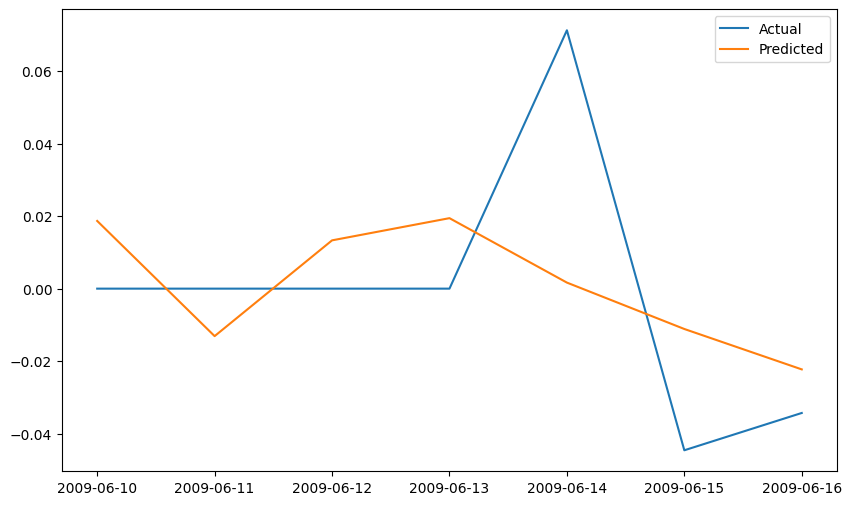

In [40]:
# Assuming 'train_data' and 'test_data' are your training and testing sets
model = sm.tsa.ARIMA(train_data, order=(7, 1, 5)) # (p,d,q) changing order based on best parameters
results = model.fit()

# Make predictions on the test set
forecast = results.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Evaluate the performance 
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')
# show summary of the model
print(results.summary())


#  plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

### ARIMA with best AIC parameters (6, 1, 9)

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE): 0.001227198320575391
Root Mean Squared Error (RMSE): 0.035031390503024444
Mean Absolute Error (MAE): 0.026432698902148073
R-squared (R²): -0.04353199534570029
Mean Absolute Percentage Error (MAPE): 3656071785570412.50%
                               SARIMAX Results                                
Dep. Variable:        sentiment_score   No. Observations:                   63
Model:                 ARIMA(6, 1, 9)   Log Likelihood                 156.092
Date:                Wed, 22 Nov 2023   AIC                           -280.184
Time:                        14:17:39   BIC                           -246.150
Sample:                    04-08-2009   HQIC                          -266.821
                         - 06-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


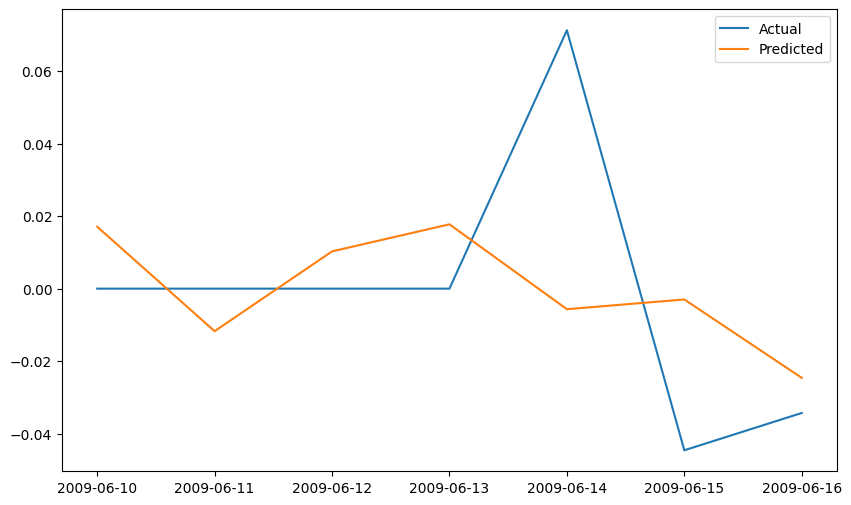

In [41]:
# Assuming 'train_data' and 'test_data' are your training and testing sets
model = sm.tsa.ARIMA(train_data, order=(6, 1, 9)) # (p,d,q) setting d=0 based on ACF lags
results = model.fit()

# Make predictions on the test set
forecast = results.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Evaluate the performance 
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

# show summary of the model
print(results.summary())


#  plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

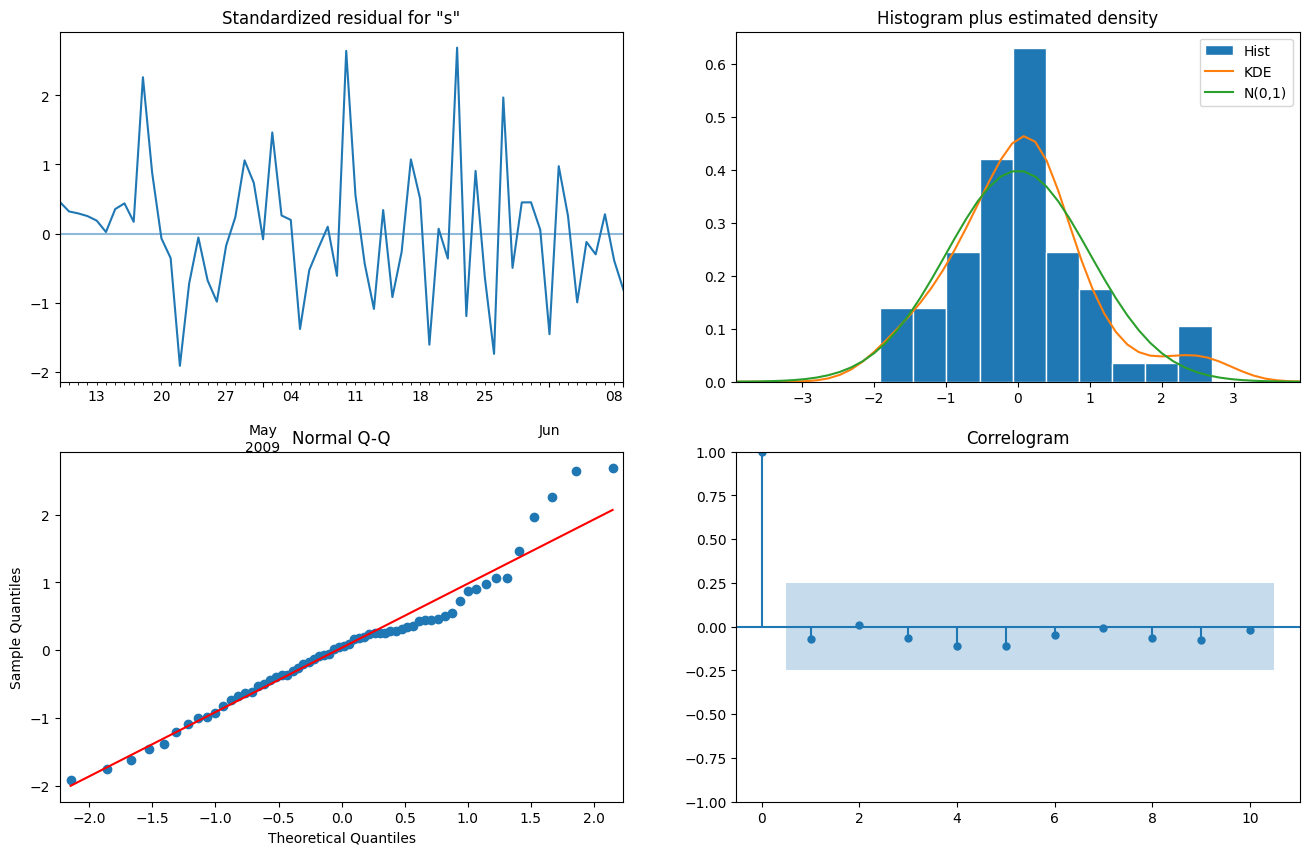

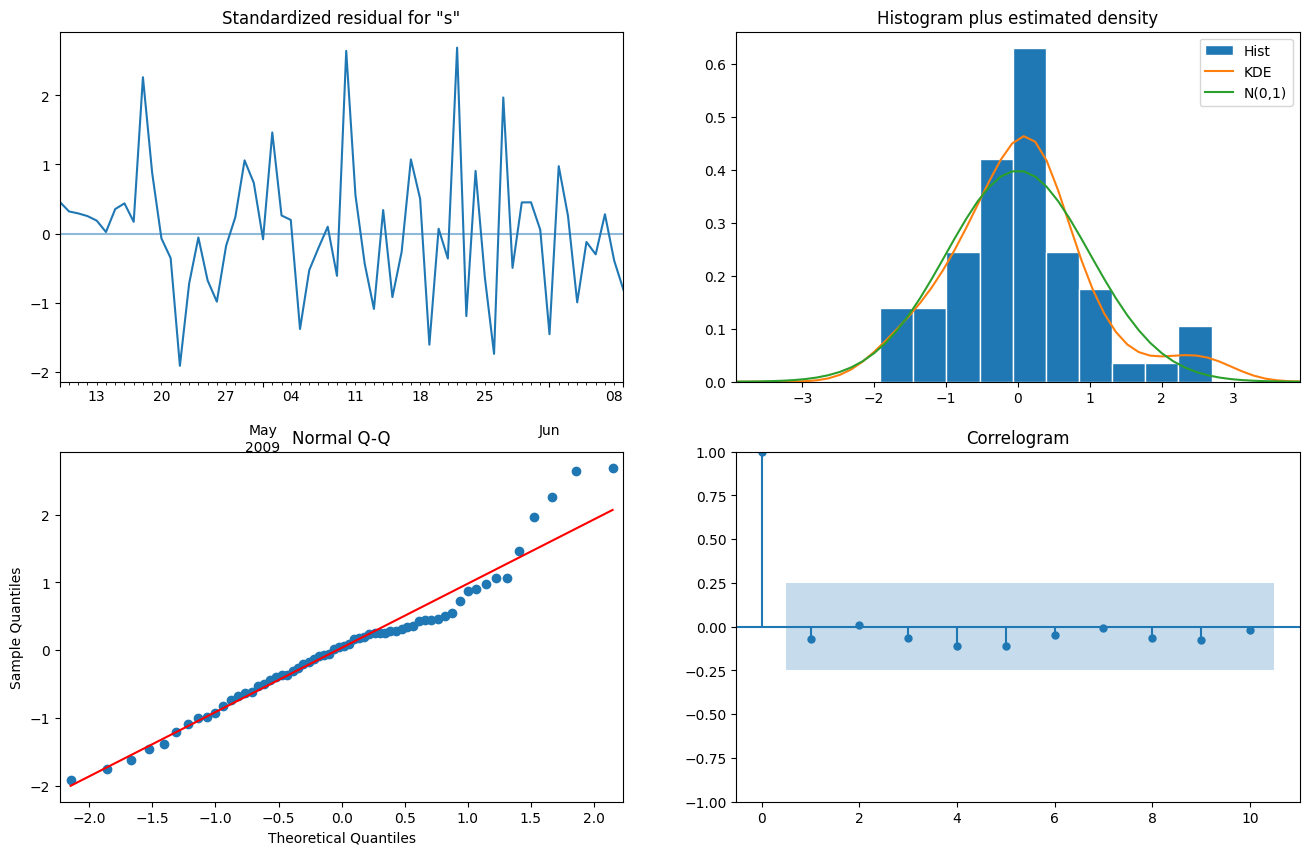

In [42]:
results.plot_diagnostics(figsize=(16,10))

#code adapted from https://www.kaggle.com/code/vipin20/arima-sarimax-exponential-smoothing-using-optuna

### ARIMA with best AIC parameters (7, 1, 7)

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error on Test Set: 0.001386116995802291
                               SARIMAX Results                                
Dep. Variable:        sentiment_score   No. Observations:                   63
Model:                 ARIMA(7, 1, 7)   Log Likelihood                 157.722
Date:                Wed, 22 Nov 2023   AIC                           -285.444
Time:                        14:17:40   BIC                           -253.537
Sample:                    04-08-2009   HQIC                          -272.916
                         - 06-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0784      5.551     -0.194      0.846     -11.959       9.802
ar.L2         -1.1544      0.794     -1.454      0.146      -2.710       0.401

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


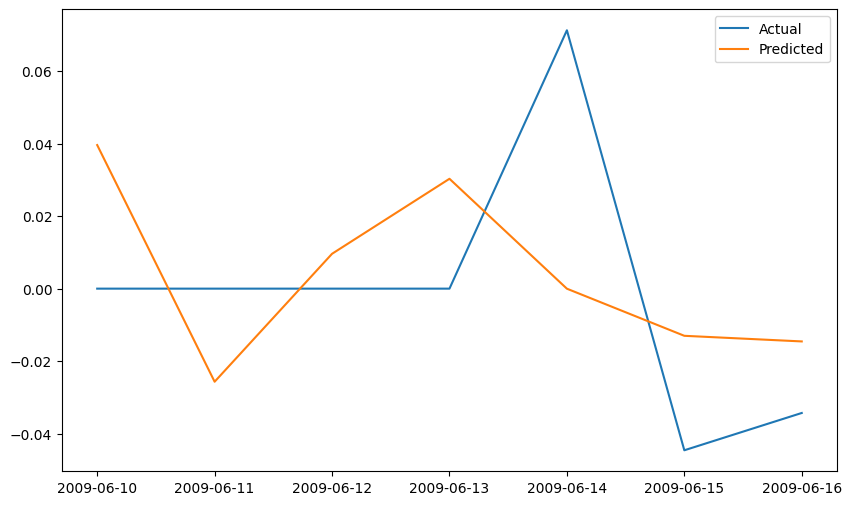

In [43]:
# Assuming 'train_data' and 'test_data' are your training and testing sets
model = sm.tsa.ARIMA(train_data, order=(7, 1, 7)) # (p,d,q) setting d=0 based on ACF lags
results = model.fit()

# Make predictions on the test set
forecast = results.get_forecast(steps=len(test_data))
predictions = forecast.predicted_mean

# Evaluate the performance (e.g., Mean Squared Error)
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error on Test Set: {mse}")

# show summary of the model
print(results.summary())


# plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

### Attempt to create a forecast for 1 week, 1 month and 3 months with ARIMAS model



In [48]:
df_diff_sqrt.tail()

date_only
2009-06-12    0.000000
2009-06-13    0.000000
2009-06-14    0.071254
2009-06-15   -0.044578
2009-06-16   -0.034292
Name: sentiment_score, dtype: float64

In [44]:
# Make forecasts for future time points

forecast_1_week = results.predict(start=df_diff_sqrt.index[-1], end=df_diff_sqrt.index[-1] + pd.DateOffset(days=7))
forecast_1_month = results.predict(start=df_diff_sqrt.index[-1], end=df_diff_sqrt.index[-1] + pd.DateOffset(days=30))
forecast_3_months = results.predict(start=df_diff_sqrt.index[-1], end=df_diff_sqrt.index[-1] + pd.DateOffset(days=90))

# Print or use the forecasts as needed
print("Forecast for 1 week:")
print(forecast_1_week)

print("\nForecast for 1 month:")
print(forecast_1_month)

print("\nForecast for 3 months:")
print(forecast_3_months)

Forecast for 1 week:
2009-06-16   -0.014559
2009-06-17   -0.001863
2009-06-18    0.006671
2009-06-19    0.004336
2009-06-20    0.008839
2009-06-21    0.004276
2009-06-22   -0.009196
2009-06-23   -0.008039
Freq: D, Name: predicted_mean, dtype: float64

Forecast for 1 month:
2009-06-16   -0.014559
2009-06-17   -0.001863
2009-06-18    0.006671
2009-06-19    0.004336
2009-06-20    0.008839
2009-06-21    0.004276
2009-06-22   -0.009196
2009-06-23   -0.008039
2009-06-24    0.000741
2009-06-25    0.003232
2009-06-26    0.004091
2009-06-27    0.004516
2009-06-28    0.000448
2009-06-29   -0.004368
2009-06-30   -0.003791
2009-07-01    0.000238
2009-07-02    0.002586
2009-07-03    0.002779
2009-07-04    0.002023
2009-07-05   -0.000166
2009-07-06   -0.002249
2009-07-07   -0.001754
2009-07-08    0.000423
2009-07-09    0.001749
2009-07-10    0.001768
2009-07-11    0.000988
2009-07-12   -0.000255
2009-07-13   -0.001112
2009-07-14   -0.000687
2009-07-15    0.000468
2009-07-16    0.001194
Freq: D, Name

The forecasting for ARIMA, after experimentation is still not perfect or close to a high accuracy but was the one i could come closer to actual results, different than 0 or continously negative, as it will be shown later with the SARIMA model. 



## Forecast for 1 week

In [50]:
import plotly.graph_objects as go
#ploting the forecast of 1 week in the same line
#  one-week forecast
forecast_start_date = df_diff_sqrt.index[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_1_week), freq='D')

# Using new df to create continuous line between the historical and forecast data
last_actual_value = df_diff_sqrt.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_1_week), index=[df_diff_sqrt.index[-1]] + list(forecast_dates))

# Create traces for original data and forecast
trace_original = go.Scatter(x=df_diff_sqrt.index, y=df_diff_sqrt, mode='lines+markers', name='Original Data', marker=dict(size=5), line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_with_last_actual.index, y=forecast_with_last_actual, mode='lines+markers', name='Forecast', marker=dict(size=5, symbol='x'), line=dict(dash='dash', color='green'))

# Create layout
layout = go.Layout(
    title='Original Scores with 1 week predictions',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Values'),
    legend=dict(x=0, y=1),
    grid=dict(columns=1, rows=1),
    xaxis_tickangle=-45
)

# Create figure and add traces
fig = go.Figure(data=[trace_original, trace_forecast], layout=layout)

# Show the interactive Plotly graph
fig.show()

## Forecast for 1 month 

In [52]:
import plotly.graph_objects as go
#ploting the combined original data with forecast of 1 month 
#  one-week forecast
forecast_start_date = df_diff_sqrt.index[-1] + pd.Timedelta(days=30)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_1_month), freq='D')

# Using new df to create continuous line between the historical and forecast data
last_actual_value = df_diff_sqrt.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_1_month), index=[df_diff_sqrt.index[-1]] + list(forecast_dates))

# Create traces for original data and forecast
trace_original = go.Scatter(x=df_diff_sqrt.index, y=df_diff_sqrt, mode='lines+markers', name='Original Data', marker=dict(size=5), line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_with_last_actual.index, y=forecast_with_last_actual, mode='lines+markers', name='Forecast', marker=dict(size=5, symbol='x'), line=dict(dash='dash', color='red'))

# Create layout
layout = go.Layout(
    title='Original Scores with 1 month predictions',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Values'),
    legend=dict(x=0, y=1),
    grid=dict(columns=1, rows=1),
    xaxis_tickangle=-45
)

# Create figure and add traces
fig = go.Figure(data=[trace_original, trace_forecast], layout=layout)

# Show the interactive Plotly graph
fig.show()

## 3 month Forecast

In [77]:
import plotly.graph_objects as go
#ploting the combined original data with forecast of 3 months 
#  
forecast_start_date = df_diff_sqrt.index[-1] + pd.Timedelta(days=90)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_3_months), freq='D')

# Using new df to create continuous line between the historical and forecast data
last_actual_value = df_diff_sqrt.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_3_months), index=[df_diff_sqrt.index[-1]] + list(forecast_dates))

# Create traces for original data and forecast
trace_original = go.Scatter(x=df_diff_sqrt.index, y=df_diff_sqrt, mode='lines+markers', name='Original Data', marker=dict(size=5), line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_with_last_actual.index, y=forecast_with_last_actual, mode='lines+markers', name='Forecast', marker=dict(size=5, symbol='x'), line=dict(dash='dash', color='green'))

# Create layout
layout = go.Layout(
    title='Original Scores with 3 months forecasting',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Values'),
    legend=dict(x=0, y=1),
    grid=dict(columns=1, rows=1),
    xaxis_tickangle=-45
)

# Create figure and add traces
fig = go.Figure(data=[trace_original, trace_forecast], layout=layout)

# Show the interactive Plotly graph
fig.show()

### Using the first diff result to see if the models show better results?
 
 
### Splitting  diff_df into train and test


In [55]:
display(diff_df.head())
diff_df.info()
display(diff_df.tail())

date_only
2009-04-08   -0.014911
2009-04-09    0.000000
2009-04-10    0.000000
2009-04-11    0.000000
2009-04-12    0.000000
Name: sentiment_score, dtype: float64

<class 'pandas.core.series.Series'>
DatetimeIndex: 79 entries, 2009-04-08 to 2009-06-25
Series name: sentiment_score
Non-Null Count  Dtype  
--------------  -----  
79 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


date_only
2009-06-21    0.008837
2009-06-22   -0.019123
2009-06-23   -0.003650
2009-06-24    0.002202
2009-06-25    0.002525
Name: sentiment_score, dtype: float64

In [56]:
# using 'diff_df' as differenced and square root transformed time series
train_size = int(len(diff_df) * 0.9)  #  split ratio as needed - 10% for testing
train_data, test_data = diff_df[:train_size], df_diff_sqrt[train_size:]


### Using Grid search to finf best parameters


Top 3 Best Parameters for the firswt differenciated series:
- AIC: -332.93867003459263, Order: (0, 1, 4)
- AIC: -332.1035658063259, Order: (0, 1, 1)
- AIC: -330.8404867170282, Order: (0, 1, 5)

In [57]:
# Define the range of values for p and q
p_values = range(0, 10)  # can be adjusted based on data and assumptions
q_values = range(0, 10)  # can be adjusted based on data and assumptions

# Create combinations of p and q values
pq_combinations = list(itertools.product(p_values, [1], q_values))

# Initialize lists to store AIC values and orders
aic_values = []
orders = []

# Grid search through combinations
for order in pq_combinations:
    try:
        model = sm.tsa.ARIMA(diff_df, order=order)
        results = model.fit()
        aic = results.aic
        aic_values.append(aic)
        orders.append(order)
    except:
        continue

# Find the indices of the top 3 AIC values
top3_indices = sorted(range(len(aic_values)), key=lambda k: aic_values[k])[:3]

# Display the top 3 best parameters
print("Top 3 Best Parameters:")
for i in top3_indices:
    print(f"AIC: {aic_values[i]}, Order: {orders[i]}")

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No f

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency 

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informati

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No f

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informati

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informati

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency 

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informati

Top 3 Best Parameters:
AIC: -332.93867003459263, Order: (0, 1, 4)
AIC: -332.1035658063259, Order: (0, 1, 1)
AIC: -330.8404867170282, Order: (0, 1, 5)


/home/hduser/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### ARIMA for AIC (0, 1, 4)

Was not able to fix the code for the apply the model to the first differentiated data. 
TO avoid more unecessary codes, will leave as raw line withjout results. 

## Seasonal Autoregressive Integrated Moving-Average (SARIMA)


     "It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modelling at the seasonal level."

In [58]:

# Fit the auto_arima model, finds the optimal order 
model = pm.auto_arima(diff_df, 
                      start_p=1, start_q=1, 
                      max_p=7, max_q=7, max_d=7,
                      start_P=0, start_Q=0, 
                      max_P=7, max_Q=7, max_D=7,
                      m=7,  # Weekly seasonality
                      seasonal=True, 
                      stepwise=True, 
                      suppress_warnings=True, 
                      error_action="ignore", 
                      trace=True)

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-339.119, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-341.856, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-341.915, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-341.285, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-343.292, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-342.769, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-342.210, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-342.319, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-340.698, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-340.711, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 0.686 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:                        SARIMAX   Log Likelihood        

In [59]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

# contrived dataset
data = diff_df


# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)) 
model_fit = model.fit(disp=False)

# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

2009-06-26   -0.00332
Freq: D, dtype: float64


/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [60]:
# Fit an ARIMA(0,0,0)(0,0,0)[7] best model based on Grid search with MSE.
model = SARIMAX(train_data, order=(0, 0, 0), seasonal_order=(0, 0, 0, 7), freq='D')
sarima = model.fit(disp=False)

# Summary of the model
print(sarima.summary())

#Makeing predictions
start_date = test_data.index[0]  # Assuming your test_data has a DateTimeIndex
end_date = test_data.index[-1]
predictions = sarima.predict(start=start_date, end=end_date)


# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('SARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)

# Print error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:        sentiment_score   No. Observations:                   71
Model:                        SARIMAX   Log Likelihood                 151.672
Date:                Wed, 22 Nov 2023   AIC                           -301.345
Time:                        14:35:41   BIC                           -299.082
Sample:                    04-08-2009   HQIC                          -300.445
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008   5.23e-05     15.610      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               417.21
Prob(Q):                              0.47   Pr

IndexError: index 0 is out of bounds for axis 0 with size 0

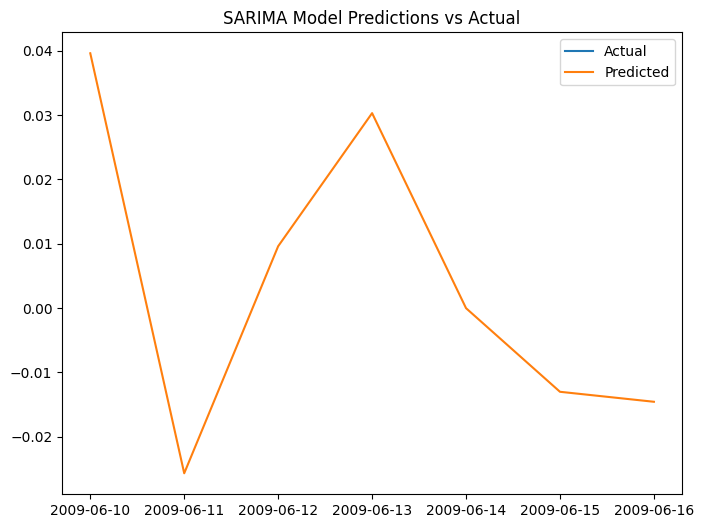

In [61]:
# Plot the actual values vs. the predictions
plt.figure(figsize=(8, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('SARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

Must double check the parameters for better perfomance. The flat line decreasing in the predicted values indicate the model is not really performing well. The negative curve means all predictions will have a continuous negative results, which are shown below as an example of the forecasting of a bad model,

#### Forecasting for 1 week, 1 month and 3 months 

In [62]:
# Make forecasts for future time points

forecast_1_week = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=7))
forecast_1_month = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=30))
forecast_3_months = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=90))

# Print or use the forecasts as needed
print("Forecast for 1 week:")
print(forecast_1_week)

print("\nForecast for 1 month:")
print(forecast_1_month)

print("\nForecast for 3 months:")
print(forecast_3_months)

Forecast for 1 week:
2009-06-25    0.0
2009-06-26    0.0
2009-06-27    0.0
2009-06-28    0.0
2009-06-29    0.0
2009-06-30    0.0
2009-07-01    0.0
2009-07-02    0.0
Freq: D, Name: predicted_mean, dtype: float64

Forecast for 1 month:
2009-06-25    0.0
2009-06-26    0.0
2009-06-27    0.0
2009-06-28    0.0
2009-06-29    0.0
2009-06-30    0.0
2009-07-01    0.0
2009-07-02    0.0
2009-07-03    0.0
2009-07-04    0.0
2009-07-05    0.0
2009-07-06    0.0
2009-07-07    0.0
2009-07-08    0.0
2009-07-09    0.0
2009-07-10    0.0
2009-07-11    0.0
2009-07-12    0.0
2009-07-13    0.0
2009-07-14    0.0
2009-07-15    0.0
2009-07-16    0.0
2009-07-17    0.0
2009-07-18    0.0
2009-07-19    0.0
2009-07-20    0.0
2009-07-21    0.0
2009-07-22    0.0
2009-07-23    0.0
2009-07-24    0.0
2009-07-25    0.0
Freq: D, Name: predicted_mean, dtype: float64

Forecast for 3 months:
2009-06-25    0.0
2009-06-26    0.0
2009-06-27    0.0
2009-06-28    0.0
2009-06-29    0.0
             ... 
2009-09-19    0.0
2009-09-20  

## Using the daily average data to apply SARIMA, considering the seasonal component


Using the parameter 'shuffle=False' to ensure that the data is split sequentially, preserving the order of the time series. 

In [63]:
data = daily_average_df
data

,sentiment_score
date_only,
2009-04-07,0.163041
2009-04-08,0.148130
2009-04-09,0.148130
2009-04-10,0.148130
2009-04-11,0.148130
...,...
2009-06-21,-0.000105
2009-06-22,-0.019228
2009-06-23,-0.022878


In [64]:
from sklearn.model_selection import train_test_split
# Adjust the test_size parameter to set the desired percentage for testing, in this case, using 10% for testing again
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)

# Print the lengths of the training and testing sets
print(f'Training set length: {len(train_data)}')
print(f'Testing set length: {len(test_data)}')

Training set length: 72
Testing set length: 8


### Grid Search for best results with pmdarima

Perform a grid search over a range of possible values for the model parameters and choose the combination that results in the best performance. 

In [65]:
# Perform an automatic grid search for SARIMA parameters
model = pm.auto_arima(data, seasonal=True, m=7, suppress_warnings=True)

# Print the summary of the model
print(model.summary())

# Split the data into training and testing sets
train_size = int(len(data) * 0.9)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit the SARIMA model on training data
sarima = pm.ARIMA(order=model.order, seasonal_order=model.seasonal_order)
sarima.fit(train_data)

# Make predictions on the test set
predictions = sarima.predict(len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)

# Print the best parameters and evaluation metrics
print(f'Best SARIMA Order: {model.order}')
print(f'Best SARIMA Seasonal Order: {model.seasonal_order}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 172.646
Date:                Wed, 22 Nov 2023   AIC                           -343.292
Time:                        14:36:32   BIC                           -340.923
Sample:                    04-07-2009   HQIC                          -342.343
                         - 06-25-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007   4.28e-05     17.283      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               578.64
Prob(Q):                              0.35   Pr

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/hduser/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



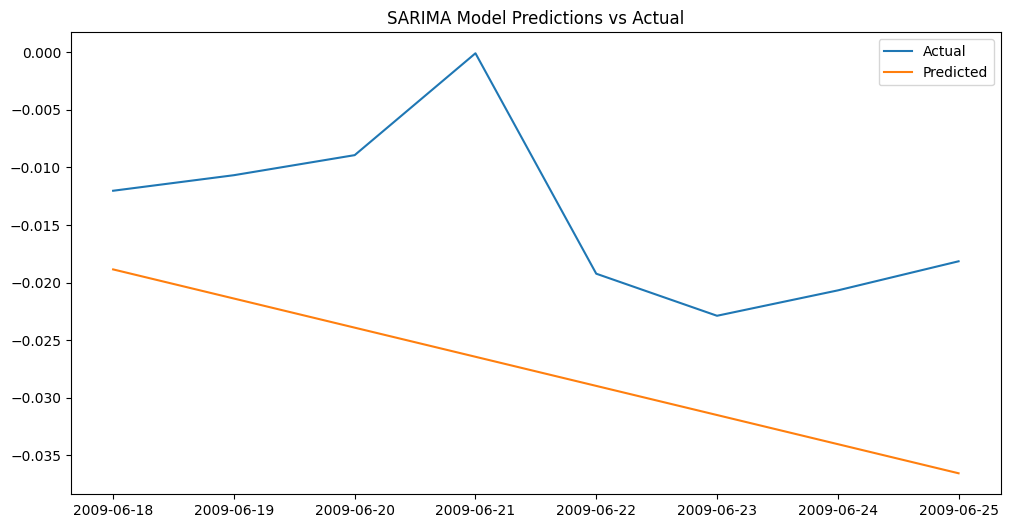

In [66]:
# plot the model

  # Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('SARIMA Model Predictions vs Actual')
plt.legend()
plt.show()


In [67]:
# Make forecasts for future time points
# Replace the numbers inside the `sarima.predict` function with the desired forecast horizon
forecast_1_week = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.Timedelta(days=7))
forecast_1_month = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=30))
forecast_3_months = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=90))

# Print or use the forecasts as needed
print("Forecast for 1 week:", forecast_1_week)
print("Forecast for 1 month:", forecast_1_month)
print("Forecast for 3 months:", forecast_3_months)


Forecast for 1 week: 2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64
Forecast for 1 month: 2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64
Forecast for 3 months: 2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64


In [68]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=['1 Week Forecast', '1 Month Forecast', '3 Months Forecast'])

# Add actual data to the first subplot
fig.add_trace(go.Scatter(x=data.index, y=data['sentiment_score'], mode='lines', name='Actual Data'), row=1, col=1)

# Add forecasts to the subplots
fig.add_trace(go.Scatter(x=forecast_1_week.index, y=forecast_1_week, mode='lines', name='1 Week Forecast'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_1_month.index, y=forecast_1_month, mode='lines', name='1 Month Forecast'), row=2, col=1)
fig.add_trace(go.Scatter(x=forecast_3_months.index, y=forecast_3_months, mode='lines', name='3 Months Forecast'), row=3, col=1)

# Update layout
fig.update_layout(title_text='SARIMA Model Forecasts', showlegend=True)

# Show interactive plot
fig.show()

In [69]:
# Create a plot for 1 Week Forecast
fig_1_week = go.Figure()

# Add actual data
fig_1_week.add_trace(go.Scatter(x=data.index, y=data['sentiment_score'], mode='lines', name='Actual Data'))

# Add 1-week forecast
fig_1_week.add_trace(go.Scatter(x=forecast_1_week.index, y=forecast_1_week, mode='lines', name='1 Week Forecast'))

# Update layout
fig_1_week.update_layout(title_text='SARIMA Model 1 Week Forecast', showlegend=True)

# Show interactive plot
fig_1_week.show()

In [70]:
# Create a plot for 1 Month Forecast
fig_1_month = go.Figure()

# Add actual data
fig_1_month.add_trace(go.Scatter(x=data.index, y=data['sentiment_score'], mode='lines', name='Actual Data'))

# Add 1-month forecast
fig_1_month.add_trace(go.Scatter(x=forecast_1_month.index, y=forecast_1_month, mode='lines', name='1 Month Forecast'))

# Update layout
fig_1_month.update_layout(title_text='SARIMA Model 1 Month Forecast', showlegend=True)

# Show interactive plot
fig_1_month.show()

In [71]:
# Create a plot for 3 Months Forecast
fig_3_months = go.Figure()

# Add actual data
fig_3_months.add_trace(go.Scatter(x=data.index, y=data['sentiment_score'], mode='lines', name='Actual Data'))

# Add 3-month forecast
fig_3_months.add_trace(go.Scatter(x=forecast_3_months.index, y=forecast_3_months, mode='lines', name='3 Months Forecast'))

# Update layout
fig_3_months.update_layout(title_text='SARIMA Model 3 Months Forecast', showlegend=True)

# Show interactive plot
fig_3_months.show()

In [72]:
# Make forecasts for future time points
# Replace the numbers inside the `sarima.predict` function with the desired forecast horizon
forecast_1_week = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=7))
forecast_1_month = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=30))
forecast_3_months = sarima.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(days=90))

# Print or use the forecasts as needed
print("Forecast for 1 week:")
print(forecast_1_week)

print("\nForecast for 1 month:")
print(forecast_1_month)

print("\nForecast for 3 months:")
print(forecast_3_months)

Forecast for 1 week:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64

Forecast for 1 month:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64

Forecast for 3 months:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64


In [73]:
# Number of days for each forecast horizon
days_1_week = 7
days_1_month = 30
days_3_months = 90

# Calculate the forecast end dates
end_date_1_week = data.index[-1] + pd.Timedelta(days=days_1_week)
end_date_1_month = data.index[-1] + pd.Timedelta(days=days_1_month)
end_date_3_months = data.index[-1] + pd.Timedelta(days=days_3_months)

# Make forecasts
forecast_1_week = sarima.predict(start=data.index[-1], end=end_date_1_week)
forecast_1_month = sarima.predict(start=data.index[-1], end=end_date_1_month)
forecast_3_months = sarima.predict(start=data.index[-1], end=end_date_3_months)

# Print or use the forecasts as needed
print("Forecast for 1 week:")
print(forecast_1_week)

print("\nForecast for 1 month:")
print(forecast_1_month)

print("\nForecast for 3 months:")
print(forecast_3_months)

Forecast for 1 week:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64

Forecast for 1 month:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64

Forecast for 3 months:
2009-06-18   -0.018856
2009-06-19   -0.021382
2009-06-20   -0.023909
2009-06-21   -0.026436
2009-06-22   -0.028963
2009-06-23   -0.031490
2009-06-24   -0.034016
2009-06-25   -0.036543
2009-06-26   -0.039070
2009-06-27   -0.041597
Freq: D, dtype: float64


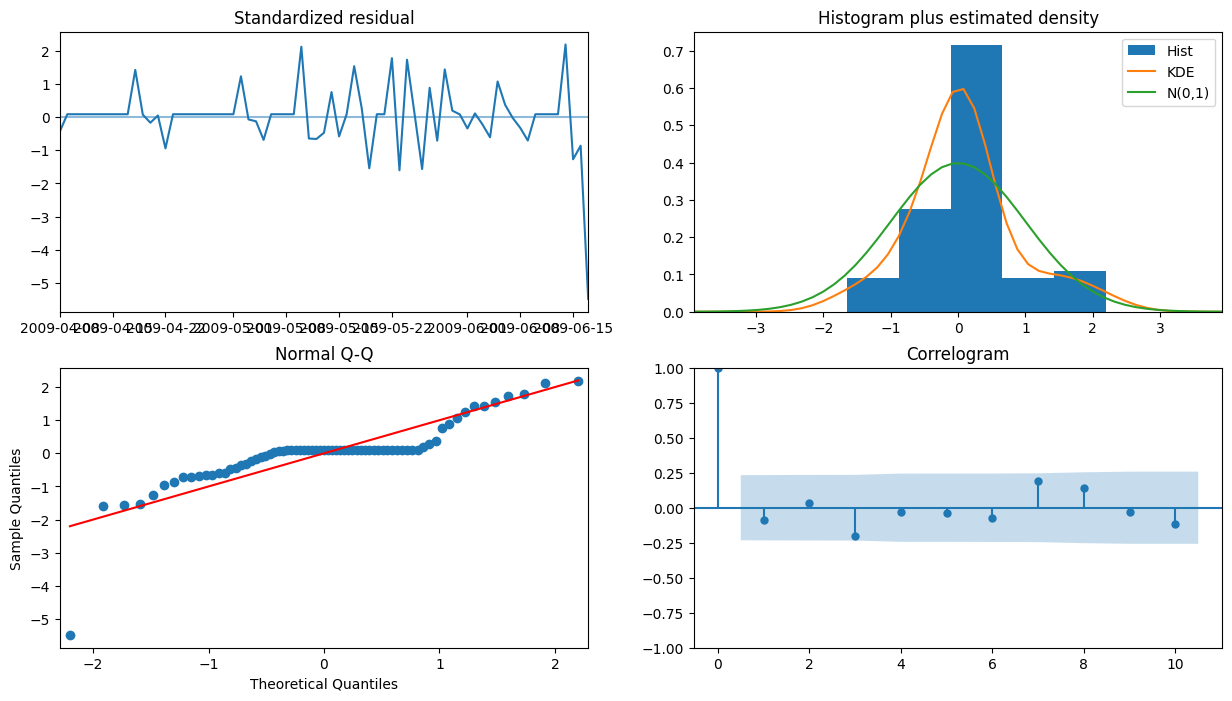

In [74]:
sarima.plot_diagnostics(figsize=(15, 8))
plt.show()